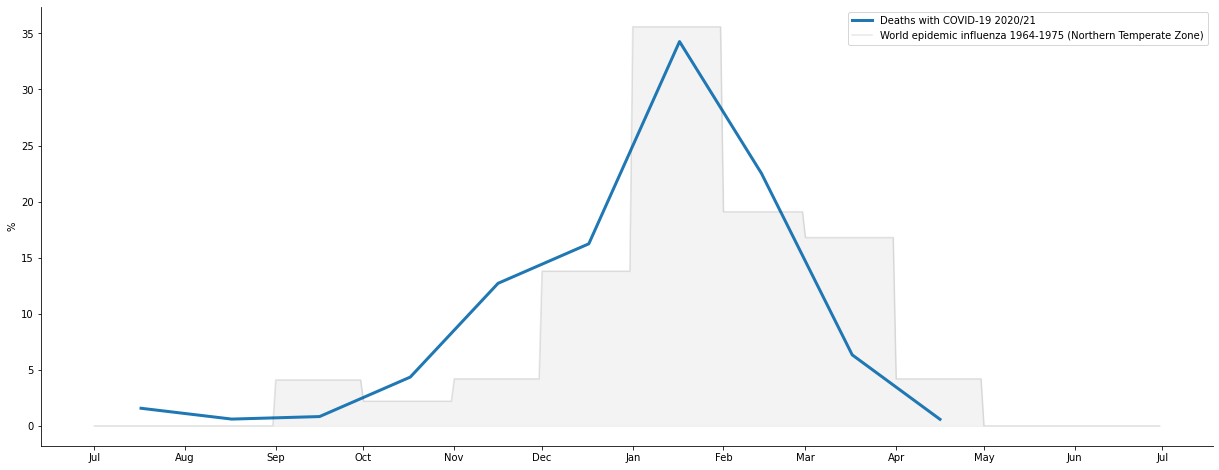

In [46]:
%matplotlib inline

import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter

def read_raw_deaths() -> pd.DataFrame:
    """Read raw ONS data for UK daily deaths where COVID-19 is mentioned on the certificate."""
    os.chdir("/Volumes/SamsungT7/Resilio/0_PROJECTS/seasonal covid/hopesimpson/data")
    skip_rows = list(range(3))+list(range(408,425))
    df = pd.read_excel(
        "publishedweek142021.xlsx",
        sheet_name="Covid-19 - Daily registrations",
        usecols="A:B",
        skiprows=skip_rows)

    # ONS date formatting is screwed: replace with generated dates
    df["Date"] = pd.date_range(start="2 Mar 2020", end="9 Apr 2021")
    df.set_index("Date", inplace=True)

    assert df["UK"].sum() == 150540 # quality check

    return df

def winter_monthly(df:pd.DataFrame) -> pd.DataFrame:
    """Compute winter monthly deaths as a %age of all winter deaths."""
    df = df.query(("Date >= '1 Jul 2020' and Date <= '30 Jun 2021'"))
    df = df.resample("M").sum()
    assert df["UK"].sum() == 95234 # quality check

    # convert to monthly percentage of total
    df = df.div(df.sum())*100

    # data is to mid April 2021: pad remaining months to end of winter period with None
    idx = pd.to_datetime([datetime(2021, 5,31,0,0,0), datetime(2021,6,30,0,0,0)])
    null_data = pd.DataFrame(columns=["UK"], data=[None, None], index=idx)
    df = df.append(null_data)

    return df

def hope_simpson() -> pd.DataFrame:
    """Construct the Hope-Simpson dataframe from monthly percentages."""
    date_index = pd.date_range(start="1 Jul 2020", end="30 Jun 2021")
    hope_simpson = {
        7:0, 8:0, 9:4.1, 10:2.2, 11:4.2, 12:13.8, 1:35.6, 2:19.1, 3:16.8, 4:4.2, 5:0, 6:0
    }
    data = [hope_simpson[date.month] for date in date_index]
    df = pd.DataFrame(data, index=date_index, columns=["Hope-Simpson"])
    return df

def create_plot(df:pd.DataFrame, df_hs:pd.DataFrame):
    """Create a plot suitable for including in substack."""
    width = 21
    height = width / 2.6
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(width,height)
    fig.patch.set_facecolor('white')
    ax.set_ylabel("%")
    ax.xaxis.set_major_locator(MonthLocator((1,2,3,4,5,6,7,8,9,10,11,12)))
    ax.xaxis.set_major_formatter(DateFormatter("%b"))
    ax.spines[['top', 'right']].set_visible(False)

    # shift COVID-19 14 days to align with middle of the month for visual appearance
    df.index = df.index.shift(-14, freq="D")

    ax.plot(df.index, df["UK"], linewidth=3, color="tab:blue", label='Deaths with COVID-19 2020/21')
    ax.plot(df_hs.index, df_hs["Hope-Simpson"], color=(0.1, 0.1, 0.1, 0.1), label="World epidemic influenza 1964-1975 (Northern Temperate Zone)")
    ax.fill_between(df_hs.index, df_hs["Hope-Simpson"], 0, color=(0.1, 0.1, 0.1, 0.05))
    ax.legend()

df = read_raw_deaths()
df = winter_monthly(df)
df_hs = hope_simpson()
create_plot(df, df_hs)



